# Fys245 Oblig 
### Johan Zapffe og Astrid Moum

Oppgaven inneholder: 
* Beregning av transmisjons- og refleksjonskoeffisient til en partikkel beskrevet som planbølge
* Numerisk propagering av bølgepakke inn mot potensialtrinn, med beregning av transmisjon og refleksjon
* Beregning av transmisjons- og refleksjonskoeffisient til en partikkel i 2 dimensjoner

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

## Oppgave 1
Beregn transmissjonskoeffisienten til en partikkel beskrevet som en planbølge. 
Planbølgen har økende energier fra 0.20 eV.

Trinnpotensial med E > V0. Planbølge kommer inn fra venstre og treffer potensialtrinnet

Transmisjonskoeffisienten ved E=0.2 eV er 0.854. 
Refleksjonskoeffisienten ved E=0.2 er 0.146


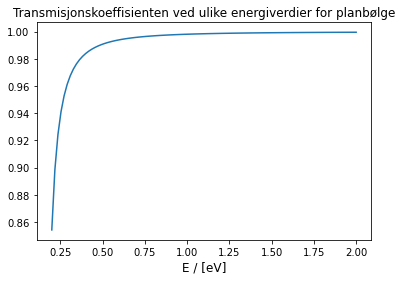

In [2]:
# ============================================================
# Definerer funksjoner for transmisjons- og refleksjonskoeffisienten
# ============================================================

def T(E, V0):
    """
    Funksjon for å kalkulere transmissjonskoeffisienten til en partikkel beskrevet 
    som en planbølge.
    Transmissjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver 
    prosentandelen av bølgen som transmitteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    T - ndarray
        1D numpy array av transmisjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    T = (4*k*k0)/(k+k0)**2
    
    return T

def R(E, V0):
    """
    Funksjon for å kalkulere refleksjonskoeffisienten til en partikkel beskrevet 
    som en planbølge.
    Refleksjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver 
    prosentandelen av bølgen som reflekteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    R - ndarray
        1D numpy array av refleksjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    R = (k - k0)**2/(k+k0)**2
    
    return R


# ===============================
# Beregner transmisjons- og refleksjonskoeffisienten for E=0.20 eV
# ===============================
E = 0.20  # eV
V0 = 0.16  # [eV]
T_coeff = T(E, V0)
R_coeff = R(E, V0)
R_coeff2 = 1-T_coeff  #ER DETTE NOK?


# Refleksjonskoeffisienten skal være lik uavhengig om du beregner den ved
# funksjon R(E, V0) eller ved R=1-T
assert R_coeff.round(5) == R_coeff2.round(5) 
                                               

print(f'Transmisjonskoeffisienten ved E={E} eV er {T_coeff.round(3)}. \n\
        Refleksjonskoeffisienten ved E={E} er {R_coeff.round(3)}')

# ================================
# Energi høyere enn potensialet
# ================================
E = np.linspace(0.20, 2, 100)  # [eV]
V0 = 0.16  # [eV]

# Lager et plot av transmissjonskoeffisienten ved ulike verdier for energi
plt.plot(E, T(E,V0))
plt.title("Transmisjonskoeffisienten ved ulike energiverdier for planbølge")
plt.xlabel("E / [eV]", fontsize=12)
plt.show()

## Oppgave 2
En bølgepakke propageres inn mot et potensialtrinn numerisk ved hjelp av Finite Difference Methods

__Funksjoner for bølgepakken__

In [9]:
# ===========================
# Definerer konstanter
# ===========================

sigma = 1* 1e-8  # [m]
m = 9.11 * 1e-31  # [kg]
h_bar = 1.055 * 1e-34 # [J*s]

# ========================================================================================
# Definerer funksjoner for potensial, tidsuavhengig bølgepakke, 
# sannsynlighetsamplitude og bølgepakke for neste tidssteg
# ========================================================================================


def V(x):
    """
    Den potensielle energien til partikkelen. Vil være:
        0 fra 0-100 nm
        V0 fra 100-200 nm
        uendelig i grensepunktene 0 og 200
    
    Inputs
    ------
    x - nparray
        array av posisjonssteg -> verdier for x fra 0 til 200
    
    Returns:
    --------
    float
        Den potensielle energien til partikkelen
    """
    inf=math.exp(15)  # Tilsvarende uendelig
    
    V_list = []
    
    for xi in x:
        if xi <= 0 or xi >= L:
            V_list.append(inf)
        elif 0 < xi < L/2:
            V_list.append(0)
        else:
            V_list.append(V0)
    return V_list


def Phi(Phi_forrige_tidssteg, x, dx, dt):
    """
    Funksjon for å regne ut ny verdi av bølgepakken Phi som en funksjon av forrige
    verdi av Phi.
    Dette gjøres for å se hvordan bølgepakken forflytter seg
    
    Inputs
    ------
    Phi_forrige_tidssteg - nparray
        Verdier for Phi ved forrige tidssteg
    
    x - nparray
        array av posisjonssteg -> verdier for x fra 0 til 200
    
    dx - int
        lengden på posisjonssteg
    
    dt -> int
        størrelsen på tidsintervall
    
    Returns
    -------
    Phi - nparray
        Nye verdier for bølgepakken Phi
    """ 
    # Regn ut den dobbeltderiverte kun for godkjente verdier
    pluss_dx = Phi_forrige_tidssteg[2:]
    minus_dx = Phi_forrige_tidssteg[:-2]
    
    # Den andre deriverte av ksi mhp x
    scnd_d_x = (pluss_dx - 2*Phi_forrige_tidssteg[1:-1] + minus_dx) / dx**2 
    
    # ==============
    # Regn ut Phi
    # ==============
    # Regner ut Phi, men ser bort ifra de ytterste verdiene ved Phi(0) og Phi(L)
    Phi = Phi_forrige_tidssteg[1:-1] + dt/(1j*h_bar) * \
        ((-h_bar**2 * scnd_d_x/(2*m)) + Phi_forrige_tidssteg[1:-1] * V(x)[1:-1])
    
    # Setter Phi(0) og Phi(L) til 0
    Phi = np.append(Phi, 0)
    Phi = np.insert(Phi, 0, 0, axis=0)
    
    return  Phi


def ksi(x, x0):
    """
    Den stasjonære bølgepakken (tidsuavhengig)
    
    Inputs
    ------
    x - nparray
        array av posisjonssteg -> verdier for x fra 0 til 200
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
    
    Returns
    -------
    float
        den stasjonære bølgepakken
    """
    k = np.sqrt(2*m*E) / h_bar
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * \
           np.exp(-((x-x0)**2 / (2*sigma**2)) + 1j*k*(x-x0))


def phi_i_andre(phi):
    """
    Funksjon for å beregne Phi^2, sannsynlighetsamplituden til Phi.
    
    Inputs
    ------
    phi - nparray
        array av phi-verdier
    
    Returns
    -------
    phi_sqrd - nparray
        sannsynlighetsamplituden til bølgefunksjonen
    
    """
    phi_sqrd = phi * np.conjugate(phi)
    
    return phi_sqrd


__Propagering av bølgepakken__

In [10]:
%matplotlib inline

# ============================
# Definerer variabler
# ============================
E = 0.20 * 1.602 * 1e-19 # [J]
V0 = 0.16  * 1.602 * 1e-19 # [J]
x0 = 50 * 1e-9  # [m]
L = 200 * 1e-9  # [m]
t = 0
dt = 2.25 * 1e-19  # [s]
dx = 1.5 * 1e-10  # [m]
x = np.linspace(0, L, int(L/dx))  # array av alle posisjonssteg
num_t_steps = 2000000 # Antall tidssteg

# Lister for å lagre de tidsstegene vi ønsker å plotte
saved_phi = []
saved_phi_sqrd = []


# ================================
# Regner ut bølgefunksjonen
# ================================
# Beregner bølgefunksjonen ved t = 0
Phi_forrige_tidssteg = ksi(x, x0) 

for i in range(num_t_steps):
    # Beregner sannsynlighetsamplituden
    phi_sqrd = phi_i_andre(Phi_forrige_tidssteg)
    
    # Lagrer hvert 5000 tidssteg 
    if i % 5000 == 0:
        saved_phi.append(Phi_forrige_tidssteg)
        saved_phi_sqrd.append(phi_sqrd)
    
    # Bereger neste tidssteg
    Phi_forrige_tidssteg = Phi(Phi_forrige_tidssteg, x, dx, dt)

__Plot og animasjon__

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


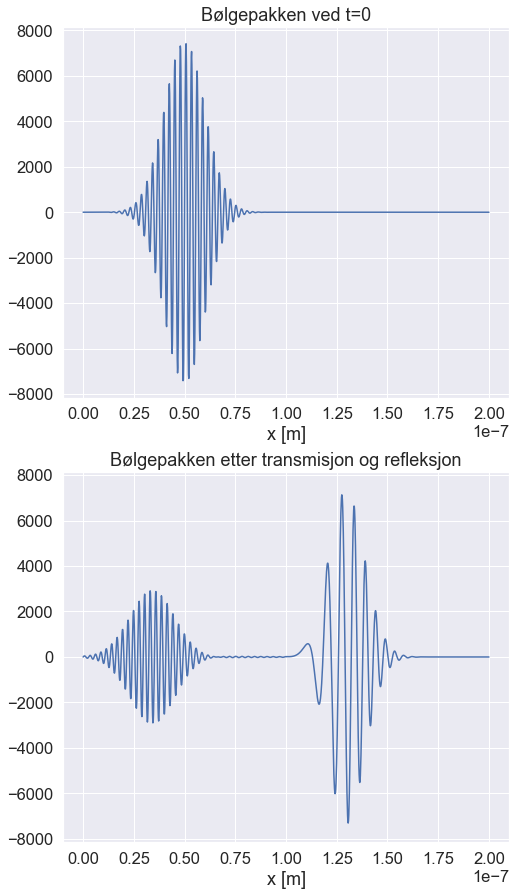

In [63]:
# =================================
# Plotter bølgepakken
# =================================
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,15))
ax1.plot(x, saved_phi[0].imag)
ax2.plot(x, saved_phi[-1])

ax1.title.set_text('Bølgepakken ved t=0')
ax2.title.set_text('Bølgepakken etter transmisjon og refleksjon')

ax1.set_xlabel('x [m]')
ax2.set_xlabel('x [m]')

plt.show()


C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


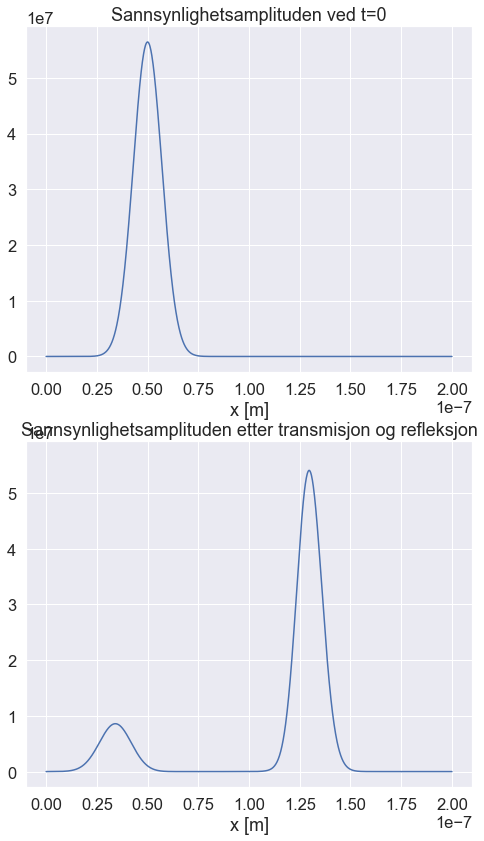

In [61]:
# ===================================
# Plotter sannsynlighetsamplituden
# ===================================
%matplotlib inline
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,14))
ax1.plot(x, saved_phi_sqrd[0])
ax2.plot(x, saved_phi_sqrd[-1])

ax1.title.set_text('Sannsynlighetsamplituden ved t=0')
ax2.title.set_text('Sannsynlighetsamplituden etter transmisjon og refleksjon')

ax1.set_xlabel('x [m]')
ax2.set_xlabel('x [m]')

plt.show()


<IPython.core.display.Javascript object>


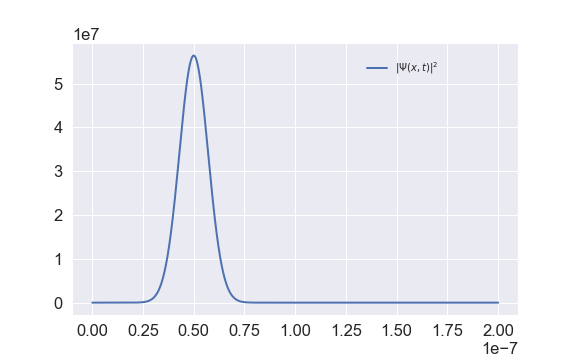

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [55]:
# ==============================
# Lag animasjon av sannsynlighetsamplituden
# ==============================
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 5))
line = ax.plot(x, saved_phi_sqrd[0], lw=2, label=r"$|\Psi(x,t)|^2$")[0]
steg = len(saved_phi_sqrd)

def animate(i):
    """Funksjon for å lage animasjon av sannsynlighetsamplituden"""
    line.set_ydata(saved_phi_sqrd[i])
    ax.legend(fontsize=10, bbox_to_anchor=(.84, .97), ncol=1, framealpha=0)

# Vis frem video
anim = FuncAnimation(fig, animate, interval=15, frames=steg-1, repeat=True)
plt.show()

# Lagre video
writergif = PillowWriter(fps=30)
anim.save('sannsynlighetsamplitude.gif', writer=writergif)

<IPython.core.display.Javascript object>


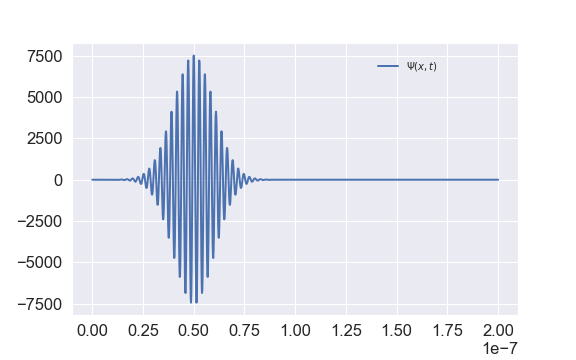

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [52]:
# ==============================
# Lag animasjon av sannsynlighetsamplituden
# ==============================
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 5))
line = ax.plot(x, saved_phi[0], lw=2, label=r"$\Psi(x,t)$")[0]
steg = len(saved_phi_sqrd)

def animate(i):
    """Funksjon for å lage animasjon av bølgepakken"""
    line.set_ydata(saved_phi[i])
    ax.legend(fontsize=10, bbox_to_anchor=(.84, .97), ncol=1, framealpha=0)

# Vis frem video
anim = FuncAnimation(fig, animate, interval=15, frames=steg-1, repeat=True)
plt.show()

# Lagre video
writergif = PillowWriter(fps=30)
anim.save('bolgepakke.gif', writer=writergif)

In [29]:
# =================================
# Beregner refleksjons- og transmisjonskoeffisient
# =================================

# Integrerer fra 100 til 200 nm
R = np.trapz(saved_phi_sqrd[-1][0:(int(len(x)/2))], x[0:(int(len(x)/2))])
print('Sannsynligheten for refleksjon: ', R.real.round(3))

T = np.trapz(saved_phi_sqrd[-1][(int(len(x)/2)):], x[(int(len(x)/2)):])
print('Sannsynligheten for transmisjon: ', T.real.round(3))

total_p = np.trapz(saved_phi_sqrd[-1], x)
print('Total sannsynlighet (R+T): ', total_p.real.round(3))


Sannsynligheten for refleksjon:  0.168
Sannsynligheten for transmisjon:  0.841
Total sannsynlighet (R+T):  1.009


<IPython.core.display.Javascript object>


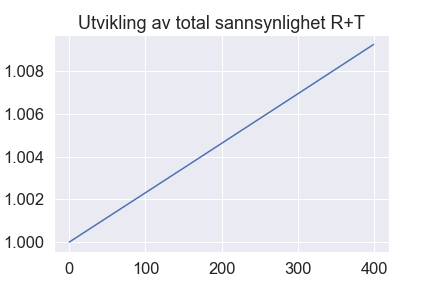

In [41]:
# ====================================
# Plotter utviklingen til den totale sannsynligheten
# (Må sørge for at denne holder seg ved 1, med maksimalt 10% feilmargin)
# ====================================

total_p_liste = [np.trapz(saved_phi_sqrd[i], x) for i in range(400)]

plt.plot(total_p_liste)
plt.title('Utvikling av total sannsynlighet R+T')
plt.show()

## Oppgave 3
Undersøkelse av hvordan innfallsvinkel påvirker sannynligheten for at elektroner blir transmittert.
Systemet blir beskrevet vha en planbølge


In [26]:
# =================
# Variabler
# =================
V0 = 0.16  # [eV]
E = np.linspace(0.4, 0.2, 10)  # eV
alpha = np.linspace(0, 30, 10)  # degrees

# ================
# Faste konstanter
# ================
m = 9.11 * 1e-31  # mass of electron [kg]
h_bar = 1.055 * 1e-34 # [J*s]


<ipython-input-56-0611fbee3d96>:31: RuntimeWarning: invalid value encountered in sqrt
  k0_x = np.sqrt(k0_2 - k_y**2)


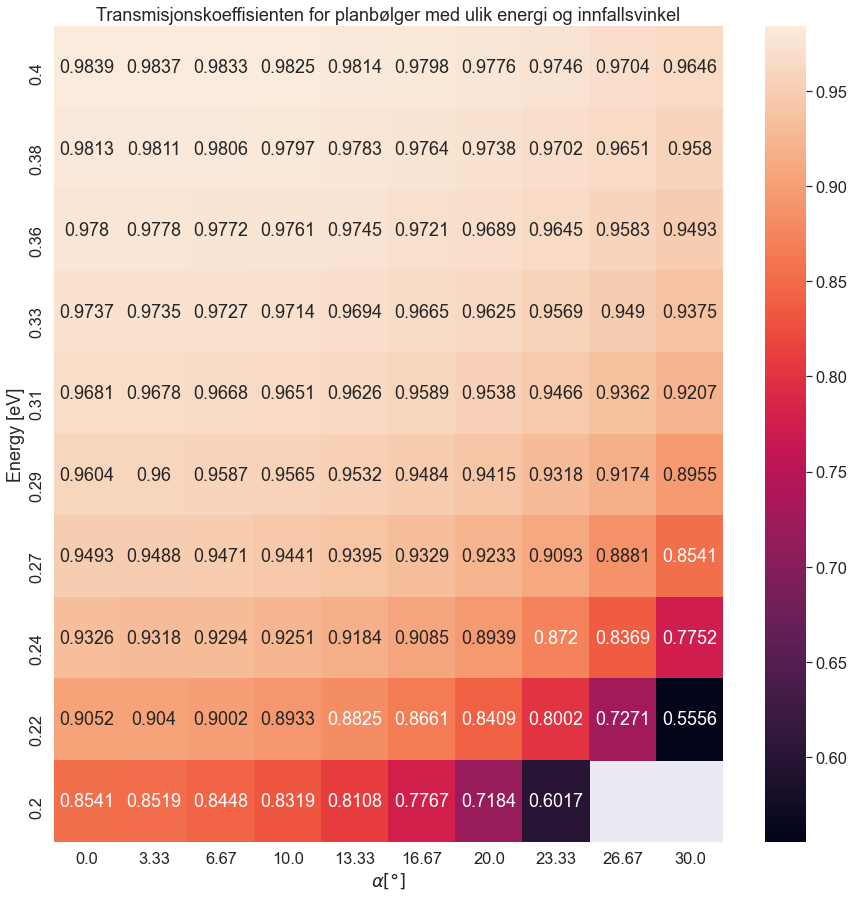

In [56]:
%matplotlib inline

def T(E, V0, alpha):
    """
    Funksjon for å beregne transmisjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen
    V0- float
        Den potensielle energien til potensialtrinnet
    alpha - float
        Innfallsvinkel til planbølgen
    
    Returns
    -------
    float
        Transmisjonskoeffisienten til planbølgen
    """
    T = np.zeros([len(E), len(alpha)])
    _alpha = np.deg2rad(alpha)
    
    for i, _E in enumerate(E):
        k = np.sqrt(2*m*_E) / h_bar  # likn 9
        k_y = k * np.sin(_alpha)  # likn 12
        k_x = k * np.cos(_alpha)
    
        k0_2 = 2*m*(_E-V0) / h_bar**2
        k0_x = np.sqrt(k0_2 - k_y**2)
        
        T[i] = 4 * k_x * k0_x / (k_x + k0_x) ** 2
    
    
    return T

# Regne ut transmisjonskoeffisienten for energi- og alpha-verdier
T_values = T(E, V0, alpha)

# Plotte transmisjonskoeffisienten
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=T_values, annot=True, fmt='.4g', \
            xticklabels=alpha.round(2), yticklabels=E.round(2))
ax.set(xlabel=r'$\alpha [\degree]$', ylabel='Energy [eV]', \
       title='Transmisjonskoeffisienten for planbølger med ulik energi og innfallsvinkel')
plt.show()